In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
from scipy.io import savemat, loadmat
import multiprocessing as mp
import statsmodels.api as sm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1D, single-sided

In [2]:
GSORT_BASE = "/Volumes/Scratch/Users/bhofflic/gsort"
ANALYSIS_BASE = "/Volumes/Scratch/Users/bhofflic/Preprocessed"
dataset = "2022-11-04-2"
wnoise = "data003"
blanked_probs = 12

estim_neg = "data004"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=0.2, noise_limit=0.1)

In [3]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [4]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [5]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)

probs_true = np.zeros(all_probs_neg.shape)
cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

[[-8.68316149 -4.21956507]]


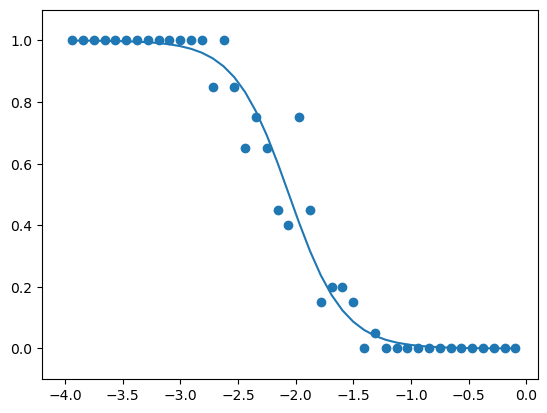

KeyboardInterrupt: Interrupted by user

In [6]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

# Multi-elec

In [7]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-5"
wnoise = "kilosort_data002/data002"

estim_neg = "data006/data006-all_v2"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
spont_limit = 0.3   # this needs to be the same value as min_prob in fit_surface()
min_active_inds = 200

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps = np.array([mutils.get_stim_amps_newlv(electrical_path, 1)] * len(trials))

clean_inds_array = np.full((all_probs.shape[0], all_probs.shape[1]), 
                            None, dtype=object)

for i in np.where((cells == 197))[0]:#range(len(all_probs)):
    for j in [1]:#range(len(all_probs[i])):

        if all_probs[i][j].max() >= spont_limit:
            print(cells[i], j+1)
            clean_inds = mutils.triplet_cleaning(amps[j], all_probs[i][j], trials[j],
                                                 return_inds=True)
            above_spont = np.where(all_probs[i][j][clean_inds] >= spont_limit)[0]
            if len(above_spont) >= min_active_inds:
                clean_inds_array[i][j] = clean_inds

197 2


In [8]:
ms = [1, 2, 3, 4, 5, 6]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [9]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [10]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

probs_true = np.zeros(all_probs.shape)
cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

197 2
[[ -9.05558266   3.64997096   1.67345683  -0.036466  ]
 [-21.04991883  -1.07399627   1.24297625 -10.        ]
 [-19.28976804   3.37701349   9.20034062   7.24376912]
 [-21.14624017  -3.49117031 -10.         -10.        ]
 [-16.92494815  -1.55365886 -10.          -0.26250502]]
639


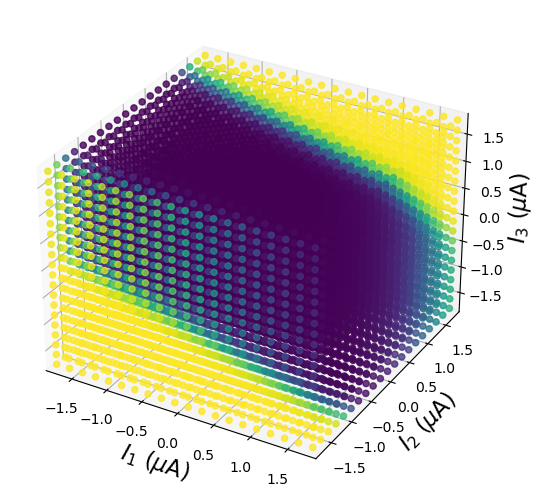

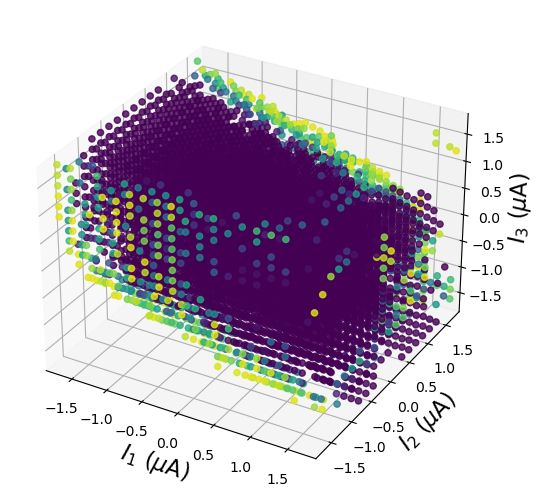

In [11]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(cells[i], j+1)
            print(params_true[i][j])
            print(len(np.where(all_probs[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][clean_inds_array[i][j], 0], 
                              amps[j][clean_inds_array[i][j], 1],
                              amps[j][clean_inds_array[i][j], 2], marker='o', 
                              c=all_probs[i][j][clean_inds_array[i][j]], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()